In [1]:
%matplotlib inline
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        
        return output


In [24]:
t = torch.rand([2, 3, 5])
print(t.shape)
torch.flatten(t, start_dim=1).shape

torch.Size([2, 3, 5])


torch.Size([2, 15])

In [3]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [4]:
train_batch_size = 2048
test_batch_size = 1024
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                        AddGaussianNoise(0., 1.3)
                    ])),
    batch_size=train_batch_size, shuffle=True, **kwargs)


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                        AddGaussianNoise(0., 1)
                    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 62, 122)


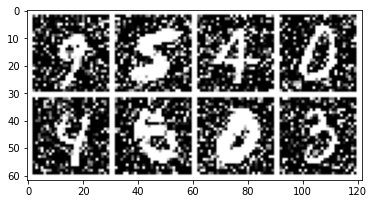

torch.Size([8, 1, 28, 28])


In [5]:
iterator = iter(test_loader)
data, target = iterator.next()

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images_show = 8
imshow(torchvision.utils.make_grid(data[:images_show,:], nrow=4, padding=2, pad_value=1))
print(data[:images_show,:].shape)

In [6]:
def train(model, device, train_loader, optimizer, epoch,log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target = F.one_hot(target,num_classes=10).type(torch.float32)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % (60000//(train_batch_size*10)) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            test_loss += F.mse_loss(output,F.one_hot(target, num_classes=10).type(torch.float32)).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [10]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=10)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

save_model = False
epochs = 10

for epoch in tqdm(range(1, epochs + 1), unit='epochs'):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
#     scheduler.step()

if save_model:
    torch.save(model.state_dict(), "mnist_cnn.pt")


torch.Size([2048, 1, 28, 28])
Train Epoch: 1 [0/60000 (0%)]	Loss: 5.932905
tensor([[-2.2709, -2.2213, -2.5690,  ..., -2.1519, -2.4789, -2.2577],
        [-2.2405, -1.9245, -2.1815,  ..., -2.3484, -2.4024, -2.7120],
        [-2.2741, -2.4139, -2.4969,  ..., -2.3313, -2.4406, -2.0405],
        ...,
        [-2.2095, -2.1273, -2.5411,  ..., -2.1744, -2.4063, -2.3097],
        [-2.4022, -2.0759, -2.3382,  ..., -2.2050, -2.2594, -2.4646],
        [-2.3276, -2.3389, -2.2675,  ..., -2.4006, -2.0266, -2.2959]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)
torch.Size([2048, 1, 28, 28])
torch.Size([2048, 1, 28, 28])
Train Epoch: 1 [4096/60000 (7%)]	Loss: 5.879522
tensor([[-2.3483, -2.3791, -2.2941,  ..., -2.1923, -2.3451, -2.2270],
        [-2.3516, -2.3727, -2.3026,  ..., -2.1872, -2.3385, -2.2257],
        [-2.3440, -2.3821, -2.2969,  ..., -2.1958, -2.3365, -2.2271],
        ...,
        [-2.3466, -2.3784, -2.2943,  ..., -2.1938, -2.3456, -2.2270],
        [-2.3488, -2.3717, -2.3013, 

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


accuracy: 37.5
(3, 62, 122)


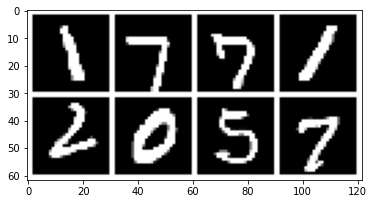

predicted [7 7 7 7 7 7 7 7]
ground_truth [1 7 7 1 2 0 5 7]


In [11]:
validation_loader =  torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                    ])),
    batch_size=8, shuffle=True, **kwargs)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        validator = iter(test_loader)
        data, target = next(validator)
        data, target = data.to(device), target.to(device)
        output = model(data)
        data = data.cpu()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    print(f'accuracy: {100. * correct / data.shape[0]}')
    return data, pred.cpu().numpy().squeeze(), target.cpu().numpy()

img, pred,ground_truth = test(model, device, validation_loader)
imshow(torchvision.utils.make_grid(img, nrow=4, padding=2, pad_value=1))
print('predicted', pred)
print('ground_truth',ground_truth)